## CSC 475 / SENG 480B - Assignment 4

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import librosa
import sklearn
import math 
import random
import scipy
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy import signal
import IPython.display as ipd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE

### Question 1

This question will build on the audio feature extraction using spectral centroid question from assignment 3. We'll perform experiments on three different genres: classical, disco, and reggae. There are 300 audio files in total, 100 for each genre. These audio files are available in the GTZAN folder in assignment resources. Here is a solution to the last question from assignment 3 (updated with new genres), which computes the mean and standard deviation of the spectral centroid for each track and plots on a scatter plot. We'll use these results for audio classification.

In [3]:
def compute_folder(folder):
    """
    Compute the spectral centroid calculations for a folder of audio files
    
    Notice that I'm also keeping track of the associated file names - don't really
    need it for this function - but will come in handy for the last part of question 1 :) 
    """
    
    results = []
    files = []
    for filename in os.listdir(folder):
        
        # Load audio file
        path = os.path.join(folder, filename)
        audio, sr = librosa.load(path)
        files.append(files)
        
        # Compute frame-by-frame spectral centroid
        sc = librosa.feature.spectral_centroid(audio)
        
        # Compute mean and standard deviation across frames
        results.append((sc.mean(), sc.std()))
    
    return np.array(results), files

In [4]:
classical, _ = compute_folder('./a4_resources/GTZAN/classical')
disco, _ = compute_folder('./a4_resources/GTZAN/disco')
reggae, _ = compute_folder('./a4_resources/GTZAN/reggae')

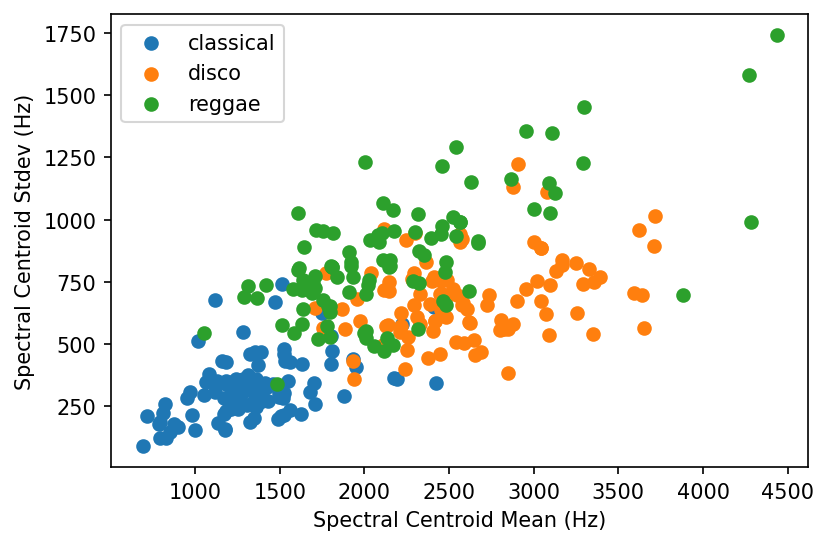

In [5]:
plt.figure(dpi=150)
plt.scatter(classical[:,0], classical[:,1], label="classical")
plt.scatter(disco[:,0], disco[:,1], label="disco")
plt.scatter(reggae[:,0], reggae[:,1], label="reggae")
plt.xlabel('Spectral Centroid Mean (Hz)')
plt.ylabel('Spectral Centroid Stdev (Hz)')
plt.legend()

**1a**

Use sckit-learn to report the 10-fold cross-validation classification accuracy for a linear support vector machine and a naive bayes classifier trained on the two features calculated above (mean centroid and std centroid) to predict the three genres. Show the confusion matrix for each case. 

(Minimum: 1 point)

In [6]:
svm = LinearSVC(max_iter=1500)
nb = MultinomialNB()

In [7]:
X = np.append(classical, disco, 0)
X = np.append(X, reggae, 0)

y_classical = np.empty(classical.size)
y_classical.fill(0)
y_disco = np.empty(disco.size)
y_disco.fill(1)
y_reggae = np.empty(reggae.size)
y_reggae.fill(2)

y = np.append(y_classical, y_disco, 0)
y = np.append(y, y_reggae, 0)

In [8]:
kf = KFold(n_splits=10, shuffle=True)
kf.split(X, y)

def evaluate(clf, X, y):
    conf_matrix = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        fit = clf.fit(X_train, y_train)
        y_pred = fit.predict(X_test)

        conf_matrix.append(confusion_matrix(y_test, y_pred))

    return conf_matrix
    
evaluate(nb, X, y)

[array([[14,  7],
        [ 1,  8]]),
 array([[18,  5],
        [ 0,  7]]),
 array([[17,  1],
        [ 1, 11]]),
 array([[19,  2],
        [ 2,  7]]),
 array([[13,  2],
        [ 5, 10]]),
 array([[14,  5],
        [ 1, 10]]),
 array([[14,  5],
        [ 1, 10]]),
 array([[22,  2],
        [ 2,  4]]),
 array([[16,  3],
        [ 2,  9]]),
 array([[18,  3],
        [ 1,  8]])]

In [9]:
scaler = sklearn.preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
evaluate(svm, X, y)

[array([[14,  2],
        [ 3, 11]]),
 array([[22,  2],
        [ 2,  4]]),
 array([[20,  1],
        [ 1,  8]]),
 array([[21,  3],
        [ 4,  2]]),
 array([[21,  2],
        [ 3,  4]]),
 array([[13,  3],
        [ 2, 12]]),
 array([[20,  0],
        [ 3,  7]]),
 array([[18,  3],
        [ 5,  4]]),
 array([[16,  0],
        [ 2, 12]]),
 array([[18,  1],
        [ 2,  9]])]

**1b**

Compute the MFCCs for each recording using the default settings of librosa. Then summarize the entire recording by taking the mean of the MFCCs across the recording as well as the mean and standard deviation across each recording. The resulting configurations will be just the mean (20 features per recording) and the mean and std (40 features per recording). Report on the 10-fold cross-validation classification accuracy and confusion matrix for these two configurations using the linear support vector machine and naive bayes classifier.

(Minimum: 1 point)

In [10]:
from librosa.feature import mfcc

def compute_folder2(folder):
    results = []
    mfccs = []
    files = []
    for filename in os.listdir(folder):
    
        # Load audio file
        path = os.path.join(folder, filename)
        audio, sr = librosa.load(path)
        files.append(path)
        
        # Compute MFCC
        mfcc_feat = mfcc(audio, sr)
        
        # Compute mean and standard deviation across frames
        features = np.append(np.mean(mfcc_feat, axis=1), np.std(mfcc_feat, axis=1))
        mfccs.append(np.mean(mfcc_feat, axis=1))
        results.append(features)

    return np.array(results), np.array(mfccs), files

c, cc, files_c = compute_folder2('./a4_resources/GTZAN/classical')
d, dd, files_d = compute_folder2('./a4_resources/GTZAN/disco')
r, rr, files_r = compute_folder2('./a4_resources/GTZAN/reggae')

files = []
files.extend(files_c)
files.extend(files_d)
files.extend(files_r)

X = np.append(c, d, 0)
X = np.append(X, r, 0)

XX = np.append(cc, dd, 0)
XX = np.append(XX, rr, 0)

In [11]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
evaluate(nb, X, y)

[array([[15,  2],
        [ 2, 11]]),
 array([[18,  1],
        [ 0, 11]]),
 array([[16,  4],
        [ 2,  8]]),
 array([[17,  4],
        [ 1,  8]]),
 array([[17,  3],
        [ 3,  7]]),
 array([[16,  4],
        [ 1,  9]]),
 array([[18,  2],
        [ 2,  8]]),
 array([[19,  2],
        [ 3,  6]]),
 array([[18,  4],
        [ 2,  6]]),
 array([[18,  2],
        [ 0, 10]])]

In [12]:
svm = LinearSVC(max_iter=2500)
scaler = sklearn.preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
evaluate(svm, X, y)

# todo XX

[array([[21,  0],
        [ 1,  8]]),
 array([[20,  5],
        [ 1,  4]]),
 array([[16,  0],
        [ 1, 13]]),
 array([[17,  2],
        [ 3,  8]]),
 array([[16,  2],
        [ 3,  9]]),
 array([[17,  2],
        [ 3,  8]]),
 array([[20,  0],
        [ 0, 10]]),
 array([[16,  1],
        [ 2, 11]]),
 array([[21,  2],
        [ 2,  5]]),
 array([[18,  4],
        [ 0,  8]])]

**1c**

Use t-SNE$^1$  to reduce the dimensionality of **the 300 by 40 feature matrix of mean and std mfccs** to a 300 by 2 feature matrix. Visualize the corresponding scatter plot with coloring of the points based on genre. How does the visual separation/overlap compare to the scatter plot of just the centroid? Run the 10-fold cross-validation classification accuaracy and show a confusion matrix for the same configurations as the full feature set, but now using only the 2 dimensions returned from t-SNE. How much accuracy is lost compared results from the previous question?

(Expected: 1 point)

$^1$https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [13]:
X_embedded = TSNE(n_components=2).fit_transform(X)

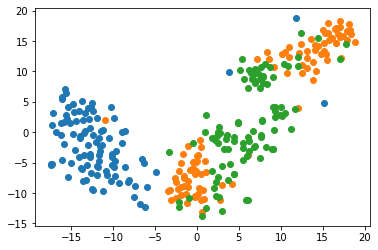

In [14]:

X_classical = X_embedded[0:99]
X_disco = X_embedded[100:199]
X_reggae = X_embedded[200:299]

#plt.scatter(X_embedded.T[0], X_embedded.T[1])

plt.scatter(X_classical.T[0], X_classical.T[1])
plt.scatter(X_disco.T[0], X_disco.T[1])
plt.scatter(X_reggae.T[0], X_reggae.T[1])

plt.show()

In [15]:
evaluate(nb, X_embedded, y)

[array([[20,  5],
        [ 1,  4]]),
 array([[17,  1],
        [ 1, 11]]),
 array([[20,  1],
        [ 5,  4]]),
 array([[20,  0],
        [ 4,  6]]),
 array([[16,  2],
        [ 1, 11]]),
 array([[21,  1],
        [ 2,  6]]),
 array([[16,  0],
        [ 0, 14]]),
 array([[20,  2],
        [ 2,  6]]),
 array([[17,  1],
        [ 5,  7]]),
 array([[18,  2],
        [ 3,  7]])]

**1d**

Let's forget about the genre labels and do some unsupervised learning. In this question we'll perform clustering on the two-dimensional results from t-SNE using K-Means$^1$. Pretend that you forgot that the files in the dataset are actually from three different genres and experiment with a few different values for number of clusters. Plot the results of clustering using three different choices for n_clusters. Make sure to plot each sample colored by the label assigned to it by K-Means. What value for n_clusters gives you the best result in your opinion? How does your plot compare to the results from the previous question?

Now, randomly select three points from two different clusters and play the associated audio files (6 in total). This is where keeping track of the audio file names during audio feature extraction would have been helpful (see code comment in the compute folder function above). 

Comment on the similarities between the audio files from the same clusters - do they sound like they are from the same genre? Does it make sense that they were clustered together?

(Expected: 1 point)

$^1$https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans

In [16]:
kmeans = KMeans(n_clusters=3).fit(X_embedded)

In [17]:
X_classical = np.empty((1, 2))
X_disco = np.empty((1, 2))
X_reggae = np.empty((1, 2))

y_pred = kmeans.predict(X_embedded)

for i in range(len(X_embedded)):
    if (y_pred[i] == 0 and not math.isinf(X_embedded[i][0])):
        X_classical = np.vstack((X_classical, X_embedded[i]))
    elif(y_pred[i] == 1 and not math.isinf(X_embedded[i][0])):
        X_disco = np.vstack((X_disco, X_embedded[i]))
    elif(y_pred[i] == 2 and not math.isinf(X_embedded[i][0])):
        X_reggae = np.vstack((X_reggae, X_embedded[i]))

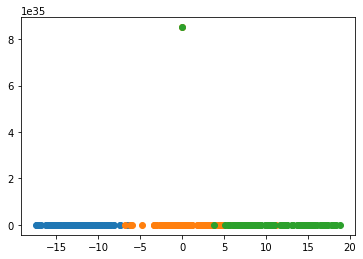

In [18]:
plt.scatter(X_classical.T[0], X_classical.T[1])
plt.scatter(X_disco.T[0], X_disco.T[1])
plt.scatter(X_reggae.T[0], X_reggae.T[1])
plt.show()

In [19]:
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2,
       2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2], d

In [20]:
y_idx = [5, 17, 40, 103, 114, 132]

import sounddevice as sd
import soundfile as sf

#track_data, sr = sf.read(files[5])
#sd.play(track_data, sr)

#track_data, sr = sf.read(files[17])
#sd.play(track_data, sr)

#track_data, sr = sf.read(files[40])
#sd.play(track_data, sr)

#track_data, sr = sf.read(files[103])
#sd.play(track_data, sr)

#track_data, sr = sf.read(files[114])
#sd.play(track_data, sr)

#track_data, sr = sf.read(files[132])
#sd.play(track_data, sr)

### Question 2

This question will look at Naive Bayes classification with song lyrics. George covers material pretty much identical to this question in the first video of the Machine Learning for MIR Kadenze course, which you can use if you need to review this material before completing the questions.

Our goal will be to build a simple Naive Bayes classifier for the MSD dataset, which uses lyrics to classify music into genres. More complicated approaches using term frequency and inverse document frequency weighting and many more words are possible but the basic concepts are the same. The goal is to understand the whole process, so **do not use existing machine learning packages** but rather build the classifier from “scratch”.

We are going to use the musicXmatch$^1$ dataset which is a large collection of song lyrics in bag-of-words format for some of the tracks contained in the Million Song dataset (MSD). 

The corresponding genre annotations, for some of the song in the musicXmatch dataset, is provided by the MSD Allmusic Genre Dataset$^2$.

We are going to use a reduced version of musicXmatch. 
3 genres: “Rap”, “Pop Rock”, and “Country”. 

The resulting genre annotated dataset is obtained by an intersection of musicXmatch and MAGD, where we select **1000 instances of each genre**, such that the three classes are balanced and easy to handle. In addition, we also reduce the cardinality of the dictionary of words used for the bag-of words lyrics representation (originally equal to 5000), to the 10 best words for each genre. Intuitively, the best words are the most frequent words for a particular genre that are not frequent among all the genres$^3$

$^1$https://labrosa.ee.columbia.edu/millionsong/musixmatch

$^2$http://www.ifs.tuwien.ac.at/mir/msd/partitions/msd-MAGD-genreAssignment.cls

$^3$The best genre words maximize the Term Frequency (TF) and Inverse Document Frequency (IDF) product. More details available at https://en.wikipedia.org/wiki/Tf-idf

The resulting dictionary of words is:

| Genre   |      |      |       |       |      |      |       |      |       |       |
|---------|------|------|-------|-------|------|------|-------|------|-------|-------|
| rap     | de   | hood | ya    | und   | yall | ich  | fuck  | shit | yo    | bitch |
| rock    | end  | wait | again | light | eye  | noth | lie   | fall | our   | away  |
| country | gone | good | night | blue  | home | long | littl | well | heart | old   |

For answering this question we provide you with:

- **data.npy** – the three genres dataset (not binarized - you will need to binarize)
- **labels.npy** – the genre labels where Rap=12, Pop Rock=1, and Country=3
- **dictionary.pickle** – the full 5000 words dictionary
- **words.npy** – the 30 best word indexes with respect to the full dictionary
- **tracks.pickle** – the track IDs of songs used (not needed for assignment, but included for those interested).

This is available on BrightSpace in the data folder in the assignment resources download. You will need to use python pickle and numpy load to load the pickle and npy files respectively.

**2a**

Write code that calculates the probabilities for each dictionary word given the genre. For the purposes of this assignment we are considering only the tracks belonging to the three genres: Rap, Rock/Pop, Country. Use add-one additive smoothing$^1$ to handle the case that there is no instance of a particular word in a genre. 

(Minimum 1pt)

$^1$https://en.wikipedia.org/wiki/Additive_smoothing


In [21]:
with open('./a4_resources/data/dictionary.pickle', 'rb') as pickle_file:
    dictionary = pickle.load(pickle_file)
    
dictionary = pd.DataFrame(dictionary)
dictionary

,0
0,i
1,the
2,you
3,to
4,and
...,...
4995,santo
4996,pe
4997,gee
4998,colleg


In [22]:
words = np.load('./a4_resources/data/words.npy')
words = pd.DataFrame(words)
words

,0
0,41
1,1948
2,169
3,217
4,1036
5,188
6,260
7,454
8,173
9,728


In [23]:
data = np.load('./a4_resources/data/data.npy')
data = pd.DataFrame(data)
data

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0,0,0,0,1,0,1,3,0,0,...,1,2,2,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,1,8,0,0,0,0
2,0,1,5,0,0,0,1,3,4,0,...,0,0,1,0,0,0,0,0,0,0
3,0,5,0,0,0,0,2,4,8,1,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,2,0,2,...,0,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,1,1,1
2996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,0,1,0
2997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2998,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,4,0,0


In [24]:
labels = np.load('./a4_resources/data/labels.npy')
labels = pd.DataFrame(labels)
#labels

In [87]:
def probability(c, data, labels, dictionary, words):
    
    num_words = data.shape[1]
    num_docs = len([x for x in labels if x == c])

    alpha = 0.1

    sums = np.zeros(num_words)
    for i in range(num_words): # for each word (30)
        for j in range(num_docs): # for each doc in CLASS
            # num of times word X appears anywhere under CLASS
            sums[i] += int(data[i][j])
        
        if (int(labels[j]) != c):
            break
        
        sums[i] += alpha
        
    sums = np.array(sums)
    
    # calculate probability
    sums = sums / num_docs
    
    map_index = []
    
    for i in range(len(words)):
        map_index.append((words[0][i], sums[i]))
    
    probs = []

    for i in range(len(dictionary)):
        probs.append([i, alpha, dictionary[0][i]])
    
    for e in map_index:
        probs[e[0]][1] = e[1]
    
    return probs

In [90]:
p = probability(12, data[0:5], labels[0][0:5], dictionary, words)
np.array(p).T

array([['0', '1', '2', ..., '4997', '4998', '4999'],
       ['0.1', '0.1', '0.1', ..., '0.1', '0.1', '0.1'],
       ['i', 'the', 'you', ..., 'gee', 'colleg', 'kad']], dtype='<U32')

**2b**

<font color='grey'>One can consider the Naive Bayes classifier a generative model that can generate binary feature vectors using the associated probabilities from the training data. The idea is similar to how we do direct sampling in Bayesian Networks and depends on generating random number from a discrete distribution (the unifying underlying theme of this assignment question). </font>

Describe how you would generate random genre “lyrics” consisting solely of the words from the dictionary using your model. Code that and show 5 examples of randomly generated tracks for each of the three genres: Rap, Rock pop, and Country; each example should consist of a subset of the words in the dictionary. 

(Minimum: 1 point)

In [91]:
def generate(dictionary):
    length = 50
    dist = dictionary[1].astype(np.float)
    words = dictionary[2]
    
    for i in range(length):
        p = np.random.choice(words, 
                             p=dist/dist.sum())
        print(p)
        
generate(np.array(p).T)

sunset
sidewalk
match
hecho
souvenir
regga
et
fe
approach
bare
gli
bless
sentiment
naiv
poni
hand
piano
meinem
wasteland
practic
betti
taught
shit
cuanto
sen
absurd
jimmi
condemn
balanc
familiar
tuyo
border
we
leav
outta
singin
oughta
axe
map
nowher
garbag
break
request
sull
heartbreak
vi
peut
fuck
bibl
through


**2c**

Explain how these probability estimates can be combined to form a Naive Bayes classifier. Code it and calculate the classification accuracy and confusion matrix that you would obtain using the whole data set for both training and testing. **Do not use any libraries such as scikit-learn but write the code directly.** 

(Expected: 2 point)

In [1]:
file = "./hit me with your best shot.txt"

test = open(file, 'r')
test = test.read()

test_words = test.split()

def naive_bayes(doc, words):
    for word in doc:
        

**2d**

Read the Wikipedia page about cross-validation in statistics$^1$. Calculate the classification accuracy and confusion matrix using the k−fold cross-validation, where k = 10. Note that you will need to generate your own splits. **Do not use any libraries such as scikit-learn but write the code directly.**

(Expected: 2 points)

$^1$https://en.wikipedia.org/wiki/Cross-validation_(statistics)
